## BTC-USD Prediction Using SBi-LSTM

In [1]:
# Library Get Dataset
import yfinance as yf

# Lib Manipulations : Time
import time as tm

# Lib Load Dataset
import numpy as np
import pandas as pd

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 1000)

# Lib Load Data Visualization
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Lib Load Preprocessing Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Lib Load Neural Networks
import tensorflow as tf
from keras.layers import LSTM
from keras.layers import GRU

from tensorflow.python.keras.layers import SimpleRNNCell
from tensorflow.python.keras.layers import RNN

# Lib Evaluate Models
import scipy.stats as sc
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Set Random Number
import random as rm
rm.seed(1234)

# Set Random Number
import numpy as np
np.random.seed(1234)

# Set Random Number
import tensorflow as tf
tf.random.set_seed(1234)

### 1. Load Dataset

In [3]:
# Set Stock Price
ticker = "BTC-USD"

# Get Dataset from yfinance
df = yf.Ticker(ticker).history(start="2015-01-01", end="2024-05-01").reset_index()

# Set Feature OHLC
df = df[["Date", "Open", "High", "Low",	"Close"]]
print(np.round(df,2))

                          Date      Open      High       Low     Close
0    2015-01-01 00:00:00+00:00    320.43    320.43    314.00    314.25
1    2015-01-02 00:00:00+00:00    314.08    315.84    313.57    315.03
2    2015-01-03 00:00:00+00:00    314.85    315.15    281.08    281.08
3    2015-01-04 00:00:00+00:00    281.15    287.23    257.61    264.20
4    2015-01-05 00:00:00+00:00    265.08    278.34    265.08    274.47
...                        ...       ...       ...       ...       ...
3403 2024-04-26 00:00:00+00:00  64485.37  64789.66  63322.40  63755.32
3404 2024-04-27 00:00:00+00:00  63750.99  63898.36  62424.72  63419.14
3405 2024-04-28 00:00:00+00:00  63423.52  64321.48  62793.60  63113.23
3406 2024-04-29 00:00:00+00:00  63106.36  64174.88  61795.46  63841.12
3407 2024-04-30 00:00:00+00:00  63839.42  64703.33  59120.07  60636.86

[3408 rows x 5 columns]


### 2. Exploration Data Analysis

- Plot OHLC

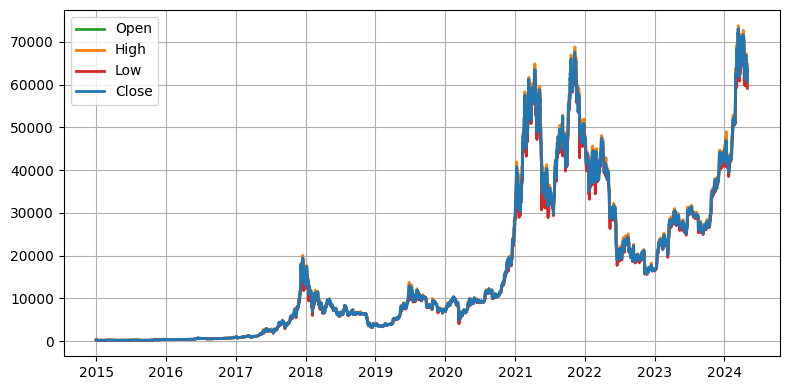

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df["Date"], df["Open"], color="tab:green", label="Open", linewidth=2)
ax.plot(df["Date"], df["High"], color="tab:orange", label="High", linewidth=2)
ax.plot(df["Date"], df["Low"], color="tab:red", label="Low", linewidth=2)
ax.plot(df["Date"], df["Close"], color="tab:blue", label="Close", linewidth=2)

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(loc="best")
ax.grid(True)

plt.tight_layout()
plt.show()

- Plot Comparing OHLC with Grouped Bar (PR)

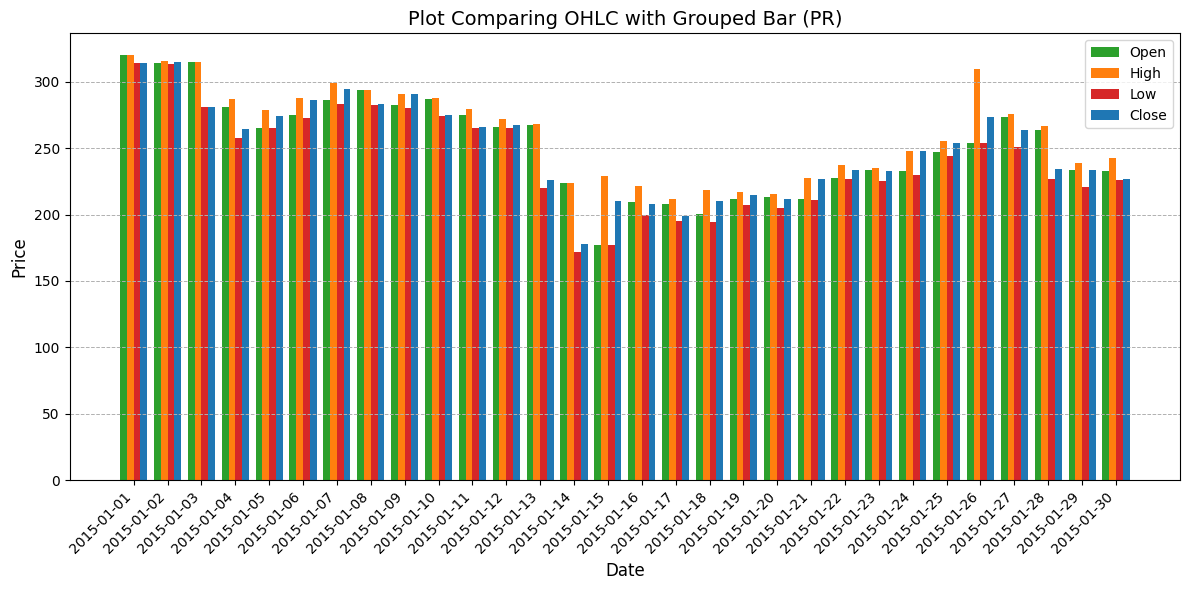

In [32]:
# Grouped Bar Plot for OHLC
fig, ax = plt.subplots(figsize=(12, 6))

# Plot grouped bar
x = np.arange(len(df["Date"][:30]))  # Limiting to 30 days for clarity
width = 0.2

ax.bar(x - 1.5*width, df["Open"][:30], width, label="Open", color="tab:green")
ax.bar(x - 0.5*width, df["High"][:30], width, label="High", color="tab:orange")
ax.bar(x + 0.5*width, df["Low"][:30], width, label="Low", color="tab:red")
ax.bar(x + 1.5*width, df["Close"][:30], width, label="Close", color="tab:blue")

# Set titles and labels
ax.set_title('Plot Comparing OHLC with Grouped Bar (PR)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)

# Formatting x-axis
ax.set_xticks(x)
ax.set_xticklabels(df["Date"][:30].dt.strftime("%Y-%m-%d"), rotation=45, ha="right")

# Additional formatting
ax.legend(loc="best")
ax.grid(axis="y", linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


- Plot Volatilitas with Comparing Line Plot and Grouped Bar (PR)

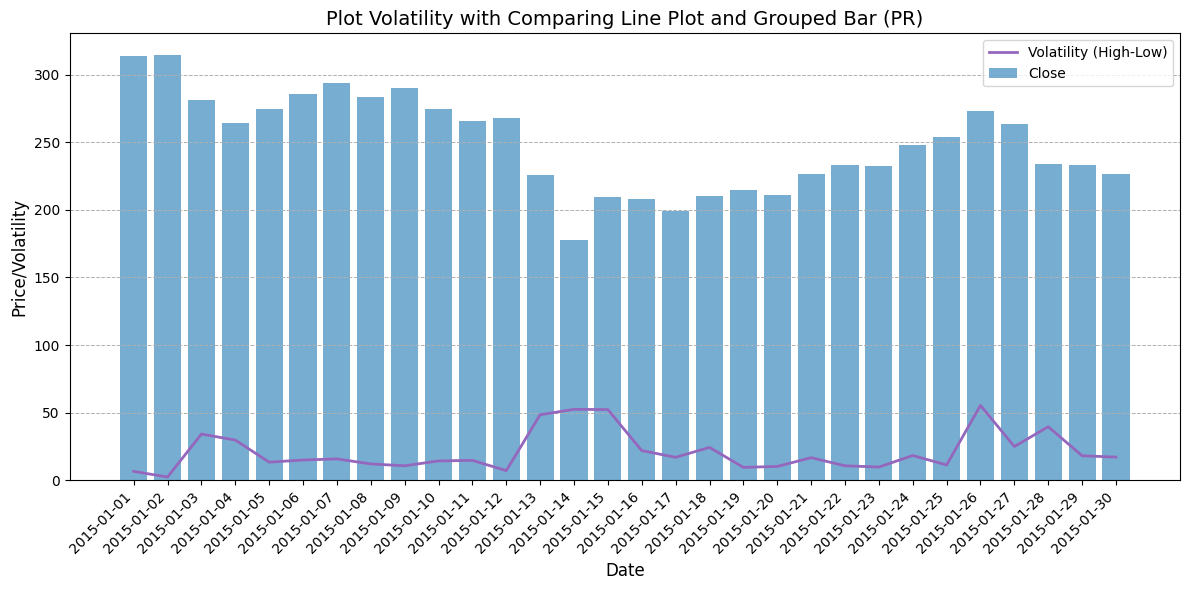

In [33]:
# Line Plot and Grouped Bar for Volatility
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate volatility
volatility = df["High"] - df["Low"]

# Line plot
ax.plot(df["Date"][:30], volatility[:30], color="tab:purple", label="Volatility (High-Low)", linewidth=2)

# Bar plot for daily Close prices
ax.bar(df["Date"][:30], df["Close"][:30], color="tab:blue", alpha=0.6, label="Close")

# Set titles and labels
ax.set_title('Plot Volatility with Comparing Line Plot and Grouped Bar (PR)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price/Volatility', fontsize=12)

# Formatting x-axis
ax.set_xticks(df["Date"][:30])
ax.set_xticklabels(df["Date"][:30].dt.strftime("%Y-%m-%d"), rotation=45, ha="right")

# Additional formatting
ax.legend(loc="best")
ax.grid(axis="y", linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


### 3. Data Preprocessing

In [7]:
# Choose Feature : Close Price
data = df.filter(["Close"])
data = data.values

In [8]:
# Show Result Feature Selection
np.round(data[:5],6)

array([[314.248993],
       [315.032013],
       [281.082001],
       [264.195007],
       [274.473999]])

In [9]:
# Show Dimension Data
print("Dimension of Dataset : "+str(data.shape))

Dimension of Dataset : (3408, 1)


- Normalization Data with MinMaxScaler

In [10]:
# Normalize Features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(np.array(data).reshape(-1,1))

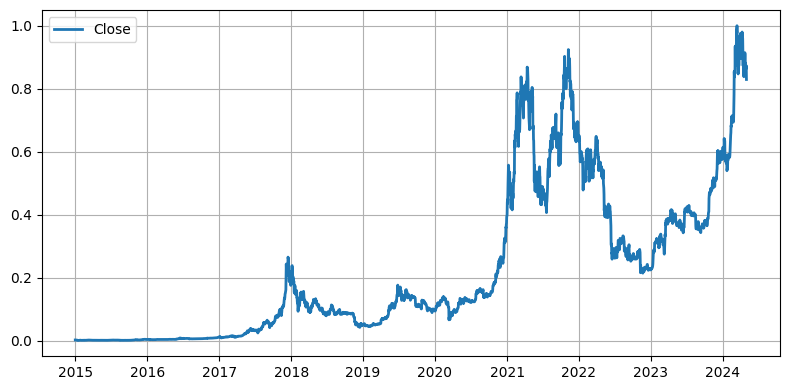

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df["Date"], scaled, color="tab:blue", label="Close", linewidth=2)

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(loc="best")
ax.grid(True)

plt.tight_layout()
plt.show()

### 4. Splitting Data

In [12]:
# Train & Test Data
train_data, test_data = train_test_split(scaled, train_size=0.8, test_size=0.2, shuffle=False)

# Check Result Splitting
print("Dimension of Data Train : "+str(train_data.shape))
print("Dimension of Data Test  : "+str(test_data.shape))

Dimension of Data Train : (2726, 1)
Dimension of Data Test  : (682, 1)


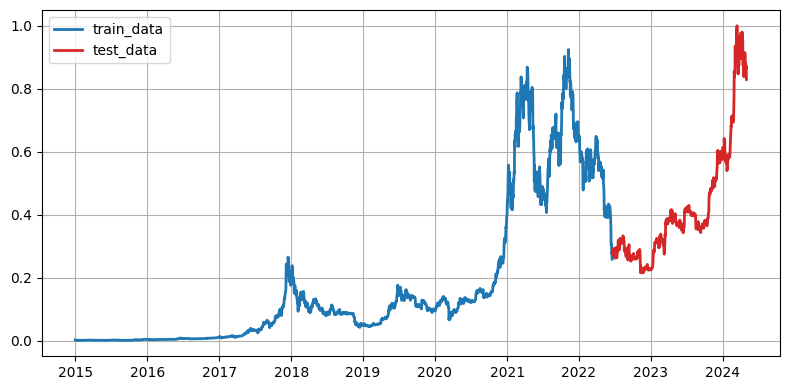

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    df["Date"].iloc[0:len(train_data)], train_data, color="tab:blue", label="train_data", linewidth=2
)
ax.plot(
    df["Date"].iloc[len(train_data):], test_data, color="tab:red", label="test_data", linewidth=2
)

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(loc="best")
ax.grid(True)

plt.tight_layout()
plt.show()

### 5. Supervised Learning on Time Series

In [14]:
# Function for Supervised Learning
def create_dataset(look_back, dataset):

    # Declare Variable X & Y
    dataX = []
    dataY = []

    # For loop for create supervised learning
    for i in range(look_back, len(dataset)):
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])

    # Return value X and Y
    return np.array(dataX), np.array(dataY)

In [15]:
# Supervised Learning
x_train, y_train = create_dataset(60, train_data)

# Result of Supervised Learning
print("Dimension of XTrain : "+str(x_train.shape))
print("Dimension of YTrain : "+str(y_train.shape))

Dimension of XTrain : (2666, 60)
Dimension of YTrain : (2666,)


In [16]:
# Supervised Learning
x_test, y_test = create_dataset(60, test_data)

# Result of Supervised Learning
print("Dimension of XTest : "+str(x_test.shape))
print("Dimension of YTest : "+str(y_test.shape))

Dimension of XTest : (622, 60)
Dimension of YTest : (622,)


In [17]:
# Reshape Input to be Sample, Time Step, and Feature
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Result of Input LSTM
print("Dimension of XTrain : "+str(x_train.shape))
print("Dimension of YTrain : "+str(y_train.shape))

# Result of Input LSTM
print("Dimension of XTest  : "+str(x_test.shape))
print("Dimension of YTest  : "+str(y_test.shape))

Dimension of XTrain : (2666, 60, 1)
Dimension of YTrain : (2666,)
Dimension of XTest  : (622, 60, 1)
Dimension of YTest  : (622,)


### 6. Implementation of Neural Network using Tensorflow

In [18]:
# PR : 
# 1. Jelaskan apa yang dimaksud dengan Neural Network
# 2. Jelaskan tentang Input Layer, Hidden Layer, dan Output Layer
# 3. Jelaskan apa yang dimaksud LSTM
# 4. Jelaskan pengaruh setting Optimizer, Batch Size, dan Epoch ke dalam Model LSTM
# 5. Jelaskan perbedaan antara Grid Search, Random Search, dan Bayesian Search untuk setting parameter LSTM

In [19]:
# Measuring Execution Time
start_time = tm.time()

In [20]:
# Set Parameter Tuning
optimizers = "adam"        # PR 6. Jelaskan perbedaan antara adamax, adam, rmsprop, SGD
batch_size = 32              # PR 7. Jelaskan pengaruh jumlah Batch Size 4, 8, 16, 32 ke Model LSTM
epoch      = 25              # PR 8. Jelaskan pengaruh jumlah Epoch 50, 75, 100 ke Model LSTM
# Yg baik sgd, batch 32, epoch 50

In [21]:
# 1. Architecture LSTM
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))),
    tf.keras.layers.Bidirectional(LSTM(units=50, return_sequences=False)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1)
])

In [22]:
# 2. Compile Models
model.compile(optimizer=optimizers, loss="mean_squared_error")

In [23]:
# 3. Fitting Models
history = model.fit(
    x=x_train, y=y_train,
    batch_size=batch_size, epochs=epoch, verbose=1,
    validation_data=(x_test, y_test),
    shuffle=False, use_multiprocessing=True,
)

Epoch 1/25
84/84 [==============================] - 17s 86ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 2/25
84/84 [==============================] - 5s 62ms/step - loss: 0.0059 - val_loss: 0.0095
Epoch 3/25
84/84 [==============================] - 5s 64ms/step - loss: 0.0044 - val_loss: 0.0087
Epoch 4/25
84/84 [==============================] - 5s 63ms/step - loss: 0.0042 - val_loss: 0.0096
Epoch 5/25
84/84 [==============================] - 5s 62ms/step - loss: 0.0059 - val_loss: 0.0090
Epoch 6/25
84/84 [==============================] - 5s 62ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 7/25
84/84 [==============================] - 5s 63ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 8/25
84/84 [==============================] - 5s 62ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 9/25
84/84 [==============================] - 5s 63ms/step - loss: 0.0072 - val_loss: 0.0116
Epoch 10/25
84/84 [==============================] - 5s 62ms/step - loss: 0.0048 - val_loss: 0.0111
Epoch 11

In [24]:
# 4. Model Predictions
predictions = model.predict(x_test, verbose=0)

In [25]:
# Measuring Execution Time
end_time = tm.time()

# Calculating the Total Execution Time
execution_time = end_time - start_time

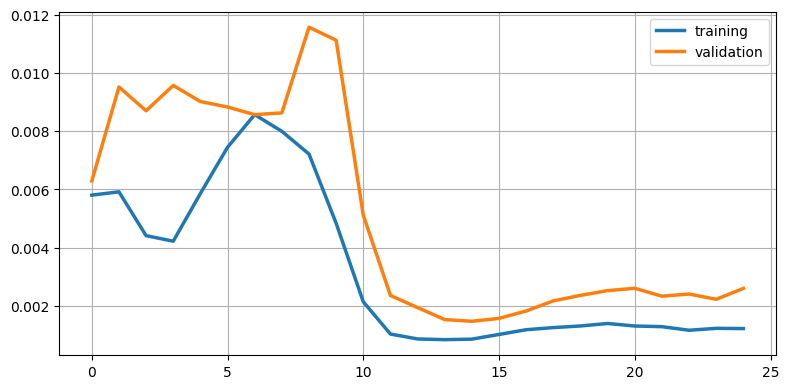

In [26]:
# Create Figure with Matplotlib
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history.epoch, history.history["loss"], label="training", linewidth=2.5)
ax.plot(history.epoch, history.history["val_loss"], label="validation", linewidth=2.5)

# Set Labels
ax.set_title("", fontsize=12)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# Return Values
plt.tight_layout()
plt.show()

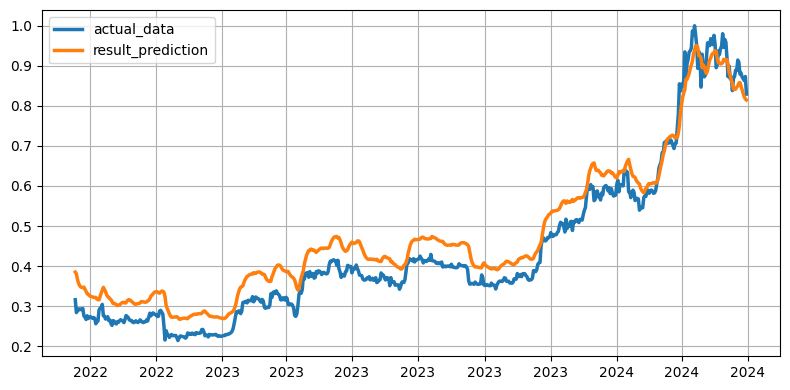

In [27]:
# Create Figure with Matplotlib
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df[["Date"]].iloc[len(y_train)+120:], y_test,
        label="actual_data", linewidth=2.5)
ax.plot(df[["Date"]].iloc[len(y_train)+120:], predictions,
        label="result_prediction", linewidth=2.5)

# Set Labels
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_title("", fontsize=12)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# Return Values
plt.tight_layout()
plt.show()

In [30]:
y_test

array([0.3159524 , 0.28392205, 0.28787934, 0.29292781, 0.29107317,
       0.29284505, 0.29101983, 0.29384383, 0.27545171, 0.27245768,
       0.26662925, 0.27597259, 0.26909812, 0.27256776, 0.27362909,
       0.27147055, 0.26958203, 0.27170293, 0.26931159, 0.25594216,
       0.26215098, 0.26269291, 0.29082963, 0.29493614, 0.29615301,
       0.30439922, 0.27595493, 0.27519207, 0.26778687, 0.26876585,
       0.27363507, 0.26392289, 0.26563227, 0.25667079, 0.25196073,
       0.2638412 , 0.26225131, 0.2573048 , 0.25545427, 0.26122303,
       0.25968508, 0.26402185, 0.26602897, 0.26409137, 0.26244961,
       0.25877377, 0.26672205, 0.27650547, 0.27408964, 0.27127402,
       0.26566959, 0.2638826 , 0.26429213, 0.26010943, 0.25887404,
       0.26032836, 0.26342085, 0.26071531, 0.25909648, 0.26184606,
       0.26572319, 0.26275576, 0.2600827 , 0.2589059 , 0.26053443,
       0.26102439, 0.26594608, 0.26290878, 0.2732    , 0.28245287,
       0.27580582, 0.28005126, 0.28311174, 0.28060338, 0.27868

In [31]:
predictions

array([[0.38490084],
       [0.38100582],
       [0.3668952 ],
       [0.35720393],
       [0.3513826 ],
       [0.34782264],
       [0.34668154],
       [0.34627402],
       [0.34736586],
       [0.34217018],
       [0.33688158],
       [0.33087718],
       [0.3295695 ],
       [0.32616797],
       [0.32469332],
       [0.323883  ],
       [0.32309955],
       [0.32173383],
       [0.32160372],
       [0.32166177],
       [0.31740564],
       [0.3163857 ],
       [0.31572172],
       [0.32470894],
       [0.3328026 ],
       [0.33950454],
       [0.346898  ],
       [0.34180808],
       [0.33640128],
       [0.3284296 ],
       [0.32336366],
       [0.3221358 ],
       [0.31831113],
       [0.31628686],
       [0.31168032],
       [0.30638242],
       [0.30674598],
       [0.30589107],
       [0.3031111 ],
       [0.30117905],
       [0.30246824],
       [0.30329365],
       [0.30560935],
       [0.30808732],
       [0.30934906],
       [0.3093406 ],
       [0.30766594],
       [0.308

### 7. Model Evaluation

In [28]:
# Function
def evaluate_models(ytrue, ypred):

    # Calculate R & MAPE
    r    = sc.mstats.pearsonr(ytrue,ypred)[0]
    mape = mean_absolute_percentage_error(ytrue,ypred)

    # Return Values
    return np.round(r,4), np.round(mape,4)

In [29]:
# Calculate Error
r, mape = evaluate_models(y_test, predictions)
print("r    : "+str(np.round(r, 4)))
print("mape : "+str(np.round(mape, 4)))
print("Time : "+"{:,.2f}".format(execution_time))

# Rentang nilai r dari 0 sampai 1, mendekati 0 artinya modelnya jelek, mendekati 1 berarti bagus
# Sedangkan rentang nilai mape, dari 0% sampai 100%, semakin mendekati 0 artinya modelnya semakin bagus, mendekati 100 artinya semakin jelek

r    : 0.9938
mape : 0.1341
Time : 144.86
